In [1]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
settings.init()
from tensorflow import keras
from tensorflow.keras import layers

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("\nTensorflow report:")
print("Devices:", tf.config.list_physical_devices('GPU'))
print("Version:", tf.__version__)

TRAIN_DATA_LEN: 3714569
VAL_DATA_LEN: 1590319

Tensorflow report:
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version: 2.3.1


In [2]:
def read_TFRecord(input_shape: dict,
                  output_shape: dict,
                  parallel_load: int,
                  path_to_file: str):
    """
    Method for reading .tfrecord file into TFRecordDataset object.
    :param input_shape: input_shape of dataset
    :param output_shape: output_shape of dataset
    :param batch_size: batch size
    :param parallel_load: number of parallel loading threads
    :return: TFRecordDataset object
    """
    featdef = dict()
    for key in input_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    for key in output_shape.keys():
        featdef[key] = tf.io.FixedLenFeature(shape=[], dtype=tf.string)
    def _parse_record(example_proto):
        """Parse a single record into image, weather labels, ground labels"""
        example = tf.io.parse_single_example(example_proto, featdef)
        x_dict = dict()
        for x_key in [k for k in example.keys() if 'x' in k]:
            data = tf.io.decode_raw(example[x_key], tf.float32)
            x_dict[x_key] = tf.reshape(data, input_shape[x_key])
        y_dict = dict()
        for y_key in [k for k in example.keys() if 'y' in k]:
            data = tf.io.decode_raw(example[y_key], tf.float32)
            y_dict[y_key] = tf.reshape(data, output_shape[y_key])
        return x_dict, y_dict
    dset = tf.data.TFRecordDataset(path_to_file, compression_type='ZLIB')
    dset = dset.map(_parse_record, num_parallel_calls=parallel_load)
    return dset


0x32_endDense_0conv_0dense_mfcc_1spec_conv_1606746080
0x32_endDense_0conv_0dense_mfcc_2spec_conv_1606746080
0x32_endDense_0conv_0dense_mfcc_3spec_conv_1606746080
0x32_endDense_0conv_1dense_mfcc_1spec_conv_1606746080
0x32_endDense_0conv_1dense_mfcc_2spec_conv_1606746080
0x32_endDense_0conv_1dense_mfcc_3spec_conv_1606746080
0x32_endDense_1conv_0dense_mfcc_1spec_conv_1606746080
0x32_endDense_1conv_0dense_mfcc_2spec_conv_1606746080
0x32_endDense_1conv_0dense_mfcc_3spec_conv_1606746080
0x32_endDense_1conv_1dense_mfcc_1spec_conv_1606746080
0x32_endDense_1conv_1dense_mfcc_2spec_conv_1606746080
0x32_endDense_1conv_1dense_mfcc_3spec_conv_1606746080
0x64_endDense_0conv_0dense_mfcc_1spec_conv_1606746080
0x64_endDense_0conv_0dense_mfcc_2spec_conv_1606746080
0x64_endDense_0conv_0dense_mfcc_3spec_conv_1606746080
0x64_endDense_0conv_1dense_mfcc_1spec_conv_1606746080
0x64_endDense_0conv_1dense_mfcc_2spec_conv_1606746080
0x64_endDense_0conv_1dense_mfcc_3spec_conv_1606746080
0x64_endDense_1conv_0dense_m

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


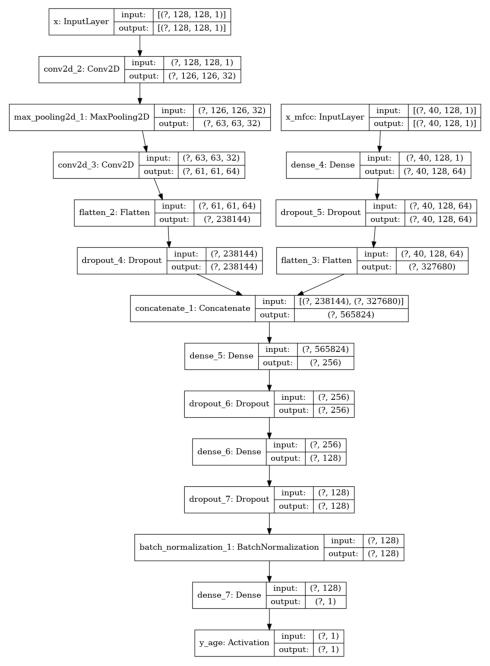

In [3]:
import tensorflow as tf

input_shape = [128, 128, 1]
input2_shape = [40, 128, 1]

def simple_model_ConvBlock(x):
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                        activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                        activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                        activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    return x

def InputDenseBlock_mfcc(x):        
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                        activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                        activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    return x

# def simple_model_DenseBlock_gender(self, conv_outputs):
#     X = tf.keras.layers.Dense(256, activation='relu')(conv_outputs)
#     X = tf.keras.layers.Dropout(0.1)(X)
#     X = tf.keras.layers.Dense(128, activation='relu')(X)
#     X = tf.keras.layers.Dropout(0.1)(X)
#     X = tf.keras.layers.BatchNormalization()(X)
#     X = tf.keras.layers.Dense(1)(X)
#     gender_output = tf.keras.layers.Activation('softmax', name='y_gender')(X)
#     return gender_output

def simple_model_DenseBlock_age(x):
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.Activation('linear', name='y_age')(x)
    return x

def assemble_full_model():
    inputs = tf.keras.Input(shape=input_shape, name='x')
    inputs2 = tf.keras.Input(shape=input2_shape, name='x_mfcc')

    conv_block = simple_model_ConvBlock(inputs)
    densed_mfcc_block  = InputDenseBlock_mfcc(inputs2)

    merged_inputs = tf.keras.layers.concatenate([conv_block, densed_mfcc_block])

    age_branch = simple_model_DenseBlock_age(merged_inputs)
    # gender_branch = self.simple_model_DenseBlock_gender(merged_inputs)

    model = tf.keras.models.Model(inputs=[inputs, inputs2],
                                outputs=[age_branch],
                                name='thragoid')
    return model
model = assemble_full_model()
tf.keras.utils.plot_model(model, to_file='model1.png', show_shapes=True)
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(plt.imread('model1.png'))
plt.axis('off')
plt.show()

In [4]:
model.compile(optimizer='adam',
              loss={'y_age': 'mse'},
              loss_weights={'y_age': 1},
              metrics={'y_age': 'mae'})

In [5]:
train_set_length = 356456 
val_set_length = 89038
"""know lengths"""
batch_size = 64
epochs = 50
steps_per_epoch = train_set_length//batch_size
validation_steps = val_set_length//batch_size

x_size_dict = {'x': [128, 128, 1], 'x_mfcc':[40, 128, 1]}
y_size_dict = {'y_age':[1], 'y_gender':[1]}
dataset_train = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_train.tfrecord'))
dataset_val = read_TFRecord(x_size_dict, y_size_dict, 2, os.path.join('data', 'tf_record', 'data_val.tfrecord'))

# def scaled(tensor, y):
#     return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
#                                                 math.reduce_min(tensor)), y1
def delete_y2(x, y):
    return x, y['y_age']


def preprocess_dataset(dataset, batch_size):
    dataset = dataset.map(delete_y2)
    dataset = dataset.shuffle(buffer_size=train_set_length//50, seed=666, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)    
    dataset = dataset.prefetch(buffer_size=2)    
    dataset = dataset.repeat(count=-1)
    return dataset

dataset_train = preprocess_dataset(dataset_train, batch_size)
dataset_val = preprocess_dataset(dataset_val, batch_size)

In [12]:
now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H_%M")
NAME = ("model_log" + date_time)
log_dir = log_dir=os.path.join('logs', str(NAME))

callbacks = [tf.keras.callbacks.TensorBoard(log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', 'checkpoints','{}.h5'.format(NAME)),
                                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
with tf.device('/device:GPU:0'):
    model.fit(
        dataset_train,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        verbose = 1,
        validation_data = dataset_val,
        validation_steps = validation_steps,
        callbacks=callbacks
        )

Epoch 1/5
5569/5569 [==============================] - ETA: 0s - loss: 0.0498 - mae: 0.1710
Epoch 00001: val_loss improved from inf to 0.03313, saving model to saved_models/checkpoints/model_log_conv_dense_dense11_30_2020_12_31.h5
5569/5569 [==============================] - 608s 109ms/step - loss: 0.0498 - mae: 0.1710 - val_loss: 0.0331 - val_mae: 0.1534
Epoch 2/5
5569/5569 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.1480
Epoch 00002: val_loss improved from 0.03313 to 0.02823, saving model to saved_models/checkpoints/model_log_conv_dense_dense11_30_2020_12_31.h5
5569/5569 [==============================] - 618s 111ms/step - loss: 0.0323 - mae: 0.1480 - val_loss: 0.0282 - val_mae: 0.1340
Epoch 3/5
5569/5569 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.1334
Epoch 00003: val_loss improved from 0.02823 to 0.02800, saving model to saved_models/checkpoints/model_log_conv_dense_dense11_30_2020_12_31.h5
5569/5569 [==============================] - 

In [6]:
model = tf.keras.models.load_model('saved_models\checkpoints\model_log12_01_2020_04_58.h5')

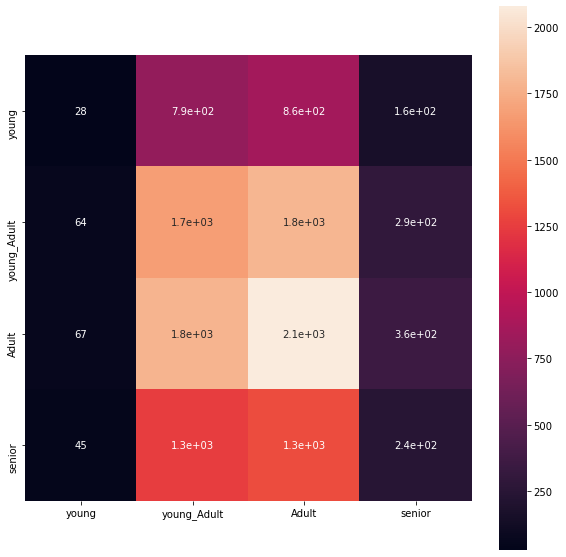

ACCURACY: 0.314609375


In [7]:
tru_y = []
for x, y in dataset_train.take(200):
    tru_y.append(y)

pred_y = model.predict(dataset_train.take(200))
testing_dataframe = pd.DataFrame({'tru':np.array(tru_y).ravel(), 'pred':pred_y.ravel()})
testing_dataframe['error'] = np.abs(testing_dataframe['tru'] - testing_dataframe['pred'])

bins = [0, 0.2, 0.4, 0.6, 1]
labels = ['young', 'young_Adult', 'Adult', 'senior']
testing_dataframe['tru'] = pd.cut(testing_dataframe['tru'], bins=bins, labels=labels)
testing_dataframe['pred'] = pd.cut(testing_dataframe['pred'], bins=bins, labels=labels)
testing_dataframe = testing_dataframe.dropna()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_dataframe.tru, testing_dataframe.pred, labels)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

from sklearn.metrics import accuracy_score
print('ACCURACY:', accuracy_score(testing_dataframe.tru, testing_dataframe.pred, normalize=True))

In [9]:
np.mean(testing_dataframe['error'])

0.18606953

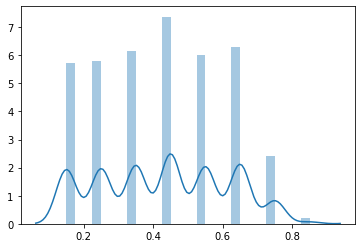

In [22]:
sns.distplot(np.array(tru_y).ravel())

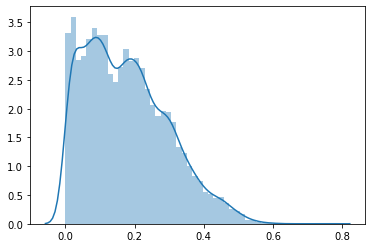

In [15]:
sns.distplot(np.array(testing_dataframe['error']))

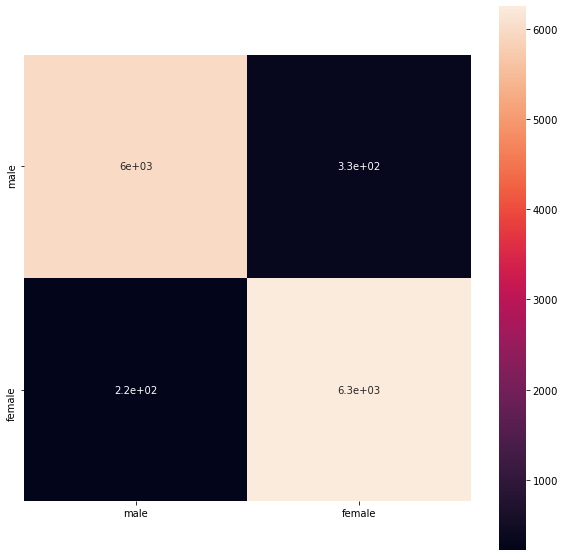

ACCURACY: 0.95734375


In [26]:
tru_y = []
for x, y in dataset_train.take(200):
    tru_y.append(y['y_gender'])

pred_y = model.predict(dataset_train.take(200))[1]
testing_dataframe = pd.DataFrame({'tru':np.array(tru_y).ravel(), 'pred':pred_y.ravel()})
bins = [-1, 0.5, 1.1]
labels = ['male', 'female']
testing_dataframe['tru'] = pd.cut(testing_dataframe['tru'], bins=bins, labels=labels)
testing_dataframe['pred'] = pd.cut(testing_dataframe['pred'], bins=bins, labels=labels)
testing_dataframe = testing_dataframe.dropna()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_dataframe.tru, testing_dataframe.pred, labels)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

from sklearn.metrics import accuracy_score
print('ACCURACY:', accuracy_score(testing_dataframe.tru, testing_dataframe.pred, normalize=True))

In [2]:
model = tf.keras.models.load_model('saved_models/checkpoints/model_log_conv_dense_dense11_30_2020_12_31.h5')

In [3]:
from modules.DataPreprocessor import DataLoader
dl = DataLoader()
def load_sample(spec_num):
    train_df = dl.train.copy()
    train_df.age = train_df.age.map({'teens': 15/100, 'twenties': 25/100,
                                        'seventies': 75/100, 'fifties': 55/100,
                                        'fourties': 45/100, 'thirties': 35/100,
                                        'sixties': 65/100, 'eighties': 85/100}
                                        )
    train_df.gender = train_df.gender.map({'male': 0, 'female': 1})
    spec = dl.make_spectrogram(spec_num)
    paded_spec = dl.pad_spec(spec)
    age = train_df.loc[spec_num][2]
    gender = train_df.loc[spec_num][3]
    x_spec = []
    x_mfcc = []
    y_age = []
    y_gender = []
    # windowing spectrograms
    for window in np.arange(0, paded_spec.shape[1]-64, 64):
        spec_window = paded_spec[:, window:window + 128]
        # making dicts for tfrecord writer
        mfcc = librosa.feature.mfcc(S=spec_window, n_mfcc=40)
        x_spec.append(spec_window)
        x_mfcc.append(mfcc)
        y_age.append(age)
        y_gender.append(gender)
    x_dict = {'x': np.array(x_spec), 'x_mfcc': np.array(x_mfcc)}
    y_dict = {'y_age':np.array(y_age), 'y_gender':np.array(y_gender)}        
    return x_dict, y_dict


In [7]:
dl.train

,client_id,path,age,gender,sentence,length,length_cut,set_type
0,7eff9a54bdb0619deffda7609d5b8565278e3328de99e6...,common_voice_en_19956141.mp3,sixties,female,He had success right off the bat with Do You B...,266112,199680,train
1,3dbc57adea9742c6782b7c88b7ac313e4bb7e26374db2e...,common_voice_en_20012566.mp3,fourties,female,"While the Doctor aids Clent, Penley leaves the...",252288,233280,train
2,5b1dd93d15c860f4d94c18ca33bb896b1b4a4f2f95f253...,common_voice_en_18343993.mp3,teens,male,The hyena proceeded to dine.,161280,84480,train
3,70c21ca1cc3de05f3c23b11615cd7d5dd078e03cda0cd4...,common_voice_en_20791392.mp3,fifties,female,"In Manchuria and Siberia, they mate during Jan...",271872,216960,train
4,db94fba2e15010f1a4aa114d910ac1e1a320c5dbd692a3...,common_voice_en_20005534.mp3,fourties,male,The reconfigured centre would have been brande...,205056,149760,train
...,...,...,...,...,...,...,...,...
38725,4ba8b91d601ee7f27be3011552ea94c8d076d9816d4a77...,common_voice_en_19769331.mp3,seventies,female,The first volume was written during Ovid's jou...,288000,165120,train
38726,afcc38200b25a04019f5e3125535f1d93674ad6f0be9ac...,common_voice_en_193416.mp3,sixties,female,Play Lil Hardin Armstrong from Itunes.,253440,120960,train
38727,e140a69135f35bc81e98140a267e18a382807d684099be...,common_voice_en_21169446.mp3,twenties,male,It is primarily a farming community.,196992,86400,val
38728,64bb74229c8a05aeeebe8aeb498d5a0389479625a0085d...,common_voice_en_19761030.mp3,twenties,male,The Ewings had thirteen children.,171648,168960,val


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


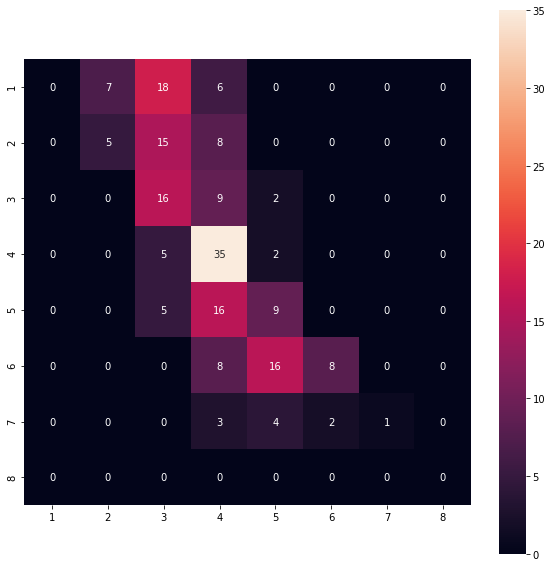

ACCURACY: 0.37
Smaller than 0.05 0.37 %


In [43]:
tru_y = []
pred_y = []
from tqdm import tqdm
for num in tqdm(np.random.randint(0, 38730, size=200)):
    sample, labels = load_sample(num)
    tru_y.append(np.mean(labels['y_age']))
    pred_y.append(np.mean(model.predict(sample)))
dataframe_y = pd.DataFrame({'tru':tru_y, 'pred':pred_y})
dataframe_y['error'] = dataframe_y['tru'] - dataframe_y['pred']

bins = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]#[0, 0.26, 0.4, 0.6, 1]
labels = ['1', '2', '3', '4', '5', '6', '7', '8']#['young', 'young_Adult', 'Adult', 'senior']
dataframe_y['tru'] = pd.cut(dataframe_y['tru'], bins=bins, labels=labels)
dataframe_y['pred'] = pd.cut(dataframe_y['pred'], bins=bins, labels=labels)
dataframe_y = dataframe_y.dropna()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataframe_y.tru, dataframe_y.pred, labels)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

from sklearn.metrics import accuracy_score
print('ACCURACY:', accuracy_score(dataframe_y.tru, dataframe_y.pred, normalize=True))
print('Smaller than 0.05', len(np.abs(dataframe_y['error'])[np.abs(dataframe_y['error'])<0.05])/len(np.abs(dataframe_y['error'])), '%')

0.375


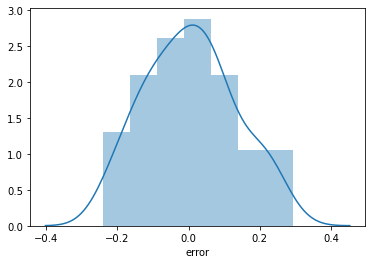

In [29]:
dataframe_y['error']

count    100.000000
mean       0.108617
std        0.083523
min        0.000279
25%        0.034793
50%        0.097118
75%        0.158488
max        0.357127
Name: error, dtype: float64

In [32]:
iter(dataset_train).next()

({'x': <tf.Tensor: shape=(64, 128, 128, 1), dtype=float32, numpy=
  array([[[[ -5.454533  ],
           [ -5.924076  ],
           [ -5.0641527 ],
           ...,
           [ -5.598113  ],
           [ -5.807213  ],
           [ -4.961132  ]],
  
          [[ -6.5429487 ],
           [ -7.001933  ],
           [ -6.14872   ],
           ...,
           [ -6.7053204 ],
           [ -6.8908834 ],
           [ -6.06308   ]],
  
          [[-21.695383  ],
           [-20.264978  ],
           [-20.513779  ],
           ...,
           [-37.603916  ],
           [-21.091236  ],
           [-26.451916  ]],
  
          ...,
  
          [[-57.290253  ],
           [-57.290253  ],
           [-57.290253  ],
           ...,
           [-57.290253  ],
           [-57.290253  ],
           [-57.290253  ]],
  
          [[-57.290253  ],
           [-57.290253  ],
           [-57.290253  ],
           ...,
           [-57.290253  ],
           [-57.290253  ],
           [-57.290253  ]],
  
      